In [71]:
import requests
# from bs4 import BeautifulSoup
import bs4
import re
import os
from tqdm import tqdm
import html5lib
import pandas as pd

In [72]:
root_url = 'http://az.lib.ru'
prefix_tails = '/janr/index_janr_5'
pages_root_count = 6
ds_path = 'dataset/raw_other/'
descr_file_path = os.path.join('dataset', 'description_other.txt')
filtered_file_path = os.path.join('dataset', 'description_other_filtered.txt')

In [73]:
rus_lit_urls = ['http://az.lib.ru/rating/litarea/index_1.shtml', 
           'http://az.lib.ru/rating/litarea/index_2.shtml', 
           'http://az.lib.ru/rating/litarea/index_4.shtml', 
           'http://az.lib.ru/rating/litarea/index_3.shtml']

In [74]:
rus_authors = []
rus_authors_filtered = ['zelinskij_f_f', 'kun_n_a', 'ershow_p_p', 'remizow_a_m']  # filter greek epic tails and other bad examples

for url in rus_lit_urls:
    try:
        r = requests.get(url, headers={'Accept-Language': 'ru-RU,ru;q=0.5'})
    except Exception:
        print(f'Page {url} connection errors!')
        break
    else:
        if r:
            payload = bs4.BeautifulSoup(r.content, features='html5lib')                        
            articles_dl = payload.find_all('dl')
            if articles_dl:
                for part in articles_dl:                
                    for tag in part.children:
                        if tag.name == 'a':
                            author = re.findall("\w{2,}", tag["href"])
                            if author[0] not in rus_authors_filtered:                          
                                rus_authors.extend(author)
                

In [103]:
for file in os.listdir(ds_path):
    os.remove(os.path.join(ds_path, file)) 

In [104]:
if os.path.exists(descr_file_path):
    os.remove(descr_file_path)
descr_file = open(descr_file_path, 'a', encoding='utf-8')

if os.path.exists(filtered_file_path):
    os.remove(filtered_file_path)
filtered_file = open(filtered_file_path, 'a', encoding='utf-8')

In [95]:
def tag_text(tag: bs4.element.Tag):
    return [" ".join([string.replace('~', '').replace('--', '-') for string in tag.stripped_strings])]

In [96]:
def postproccess_text(text: str):
    text = re.sub('(\[[\w\s]*\])', "", text)
    return text.strip()

In [97]:
def add_par(input_data: list, output_data: list):
    for tag in input_data:
        if 'примечани' in tag.text.lower(): 
            break
        elif 'КОММЕНТАРИ'.lower() in tag.text.lower(): 
            break
        for child in tag.contents:
            if child.name == 'i':
                continue
            elif 'Типография'.lower() in tag.text.lower():
                continue
            elif 'Оригинал находится здесь:'.lower() in tag.text.lower():
                continue
            elif 'Источник текста:'.lower() in tag.text.lower():
                continue
            elif 'В кн.:'.lower() in tag.text.lower():
                continue
            elif 'OCR'.lower() in tag.text.lower():
                continue
            elif 'Иллюстраци'.lower() in tag.text.lower():
                continue
            elif 'Издание книгопродавца'.lower() in tag.text.lower():
                continue
            elif 'Книга:'.lower() in tag.text.lower():
                continue
            elif 'Собрание сочинений'.lower() in tag.text.lower():
                continue     
            elif 'Набор:'.lower() in tag.text.lower():
                continue
            elif re.findall(' том.?\d+', tag.text.lower()):
                continue                       
            elif child.name == 'div':
                continue
            elif child.name == 'font':
                if len(child.contents) > 0 and child.contents[0].name is not None:
                    continue
                else:    
                    output_data.extend(tag_text(tag))
                    break
            elif isinstance(child, bs4.element.Comment):
                continue
            elif isinstance(child, bs4.element.NavigableString):
                if re.match("([А-Я]{1}\.)", str(child).strip()) is not None:  # skip started initials "В. П. Авенариус -- Детские сказки"
                    continue
                elif re.match('.*[a-zA-Z]{2}.*', str(child).strip()) is not None: # skip strings with 2 or more eng letters  
                    continue
                elif not re.findall('[\w]', str(child).strip()):  # skip strings without words "---------"
                    continue
                elif re.findall('([1-2][0|7-9]\d\d)', str(child).strip()): # skip strings with years, examples "1891" "1992"
                    continue
                elif re.findall(' стр.', str(child).strip()):  # skip strings with pages count - 'Том 3, стр. 289 - 292.'
                    continue
                elif len(str(child).strip()) > 2:
                    output_data.extend([str(child).strip()])
                else:
                    print('Fail child tag', type(child), repr(child))
                    
            else:
                # print('Fail child tag', type(child), repr(child))
                continue
    

In [ ]:
for i in range(1, pages_root_count + 1):
    try:
        r_url = f'{root_url}{prefix_tails}-{i}.shtml'
        r = requests.get(r_url, headers={'Accept-Language': 'ru-RU,ru;q=0.5'})
    except Exception:
        print(f'Page {r_url} connection errors!')
        break
    else:
        if r:
            payload = bs4.BeautifulSoup(r.content, features='html5lib')                        
            articles_li = payload.find_all('li')
            urls = []
            if articles_li:
                for part in articles_li:                
                    for tag in part.children:
                        if tag.name == 'a' and 'text' in tag["href"]:                            
                            urls.append(tag["href"])
            
            for url in urls:
                author = re.findall("\w{2,}", url)[0]
                if author in rus_authors:
                    r = requests.get(f'{root_url}{url}', headers={'Accept-Language': 'ru-RU,ru;q=0.5'})
                    if r:
                        payload = bs4.BeautifulSoup(r.content, features='html5lib')
                        title = re.sub('[^а-яА-Я\-\s]', '', payload.title.text).replace('Классика', '').strip()
                        articles_dd = payload.find_all('dd')
                        
                        if articles_dd:
                            pars = []
                            add_par(articles_dd, pars)  
                            if pars:
                                text = '\n'.join(pars)
                                text = postproccess_text(text)
                                
                                if len(text.split()) < 2000:
                                    descr_file.write(f'{title} | {len(text.split())} | {root_url}{url}\n')
                                
                                    with open(os.path.join(ds_path, f'{title}.txt'), 'w', encoding='utf-8') as f:
                                        f.write(text)
                                else:
                                    filtered_file.write(f'{title} | {len(text.split())} | {root_url}{url}\n')
                            else:
                                print(f'Fail, cant find paragraphs: {title} | {root_url}{url}')
descr_file.close()
filtered_file.close()

- Fail, cant find paragraphs: Замятин Евгений Иванович Арапы Церковь Божия | http://az.lib.ru/z/zamjatin_e_i/text_0140.shtml
- Fail, cant find paragraphs: Лесков Николай Семенович Сказание о Федоре-христианине и о друге его Абраме-жидовине | http://az.lib.ru/l/leskow_n_s/text_0248.shtml
- Fail, cant find paragraphs: Черный Саша Штабс-капитанская сласть | http://az.lib.ru/c/chernyj_s/text_0270.shtml
- Fail, cant find paragraphs: Черный Саша Правдивая колбаса | http://az.lib.ru/c/chernyj_s/text_0280.shtml
- Fail, cant find paragraphs: Киреевский Иван Васильевич Опал | http://az.lib.ru/k/kireewskij_i_w/text_0030.shtml
- Fail, cant find paragraphs: Андреев Леонид Николаевич Сказочки не совсем для детей | http://az.lib.ru/a/andreew_l_n/text_0370.shtml
- Fail, cant find paragraphs: Жуковский Василий Андреевич Война мышей и лягушек | http://az.lib.ru/z/zhukowskij_w_a/text_0060.shtml
- Fail, cant find paragraphs: Одоевский Владимир Федорович Городок в табакерке | http://az.lib.ru/o/odoewskij_w_f/text_0044.shtml
- Fail, cant find paragraphs: Лермонтов Михаил Юрьевич Ашик-Кериб | http://az.lib.ru/l/lermontow_m_j/text_0460.shtml
- Fail child tag <class 'bs4.element.NavigableString'> ' да '
- Fail child tag <class 'bs4.element.NavigableString'> ' да '
- Fail child tag <class 'bs4.element.NavigableString'> 'на '
- Fail child tag <class 'bs4.element.NavigableString'> 'да '
- Fail child tag <class 'bs4.element.NavigableString'> 'в '
- Fail child tag <class 'bs4.element.NavigableString'> 'в '
- Fail, cant find paragraphs: Одоевский Владимир Федорович Необойднный дом | http://az.lib.ru/o/odoewskij_w_f/text_0092.shtml
- Fail, cant find paragraphs: Жуковский Василий Андреевич Сказка о царе Берендее | http://az.lib.ru/z/zhukowskij_w_a/text_0040.shtml
- Fail, cant find paragraphs: Одоевский Владимир Федорович Сказки дедушки Иринея | http://az.lib.ru/o/odoewskij_w_f/text_0310.shtml
- Fail, cant find paragraphs: Черный Саша Антошина беда | http://az.lib.ru/c/chernyj_s/text_0260.shtml
- Fail child tag <class 'bs4.element.NavigableString'> ' \nи '
- Fail child tag <class 'bs4.element.NavigableString'> '\xa0\xa0 Но '
- Fail child tag <class 'bs4.element.NavigableString'> ' да '
- Fail child tag <class 'bs4.element.NavigableString'> ' г.\n'
- Fail child tag <class 'bs4.element.NavigableString'> '\xa0\xa0 К'
- Fail child tag <class 'bs4.element.NavigableString'> '\xa0\xa0 В\n'
- Fail, cant find paragraphs: Черский Леонид Федорович Хаджи-Агмат | http://az.lib.ru/c/cherskij_l_f/text_04_hadzhi-agmat.shtml
- Fail, cant find paragraphs: Сомов Орест Михайлович В поле съезжаются родом не считаются | http://az.lib.ru/s/somow_o_m/text_0090.shtml

In [55]:
descr_file.close()
filtered_file.close()

# test

In [ ]:
# url = 'http://az.lib.ru/g/garshin_w_m/text_0080.shtml'
url = 'http://az.lib.ru/a/awenarius_w_p/text_1905_drakonov_utes.shtml'


try:
    r = requests.get(url, headers={'Accept-Language': 'ru-RU,ru;q=0.5'})
except Exception:
    print(f'Page {url} connection errors!')
else:
    if r:
        payload = bs4.BeautifulSoup(r.content, "html5lib")                        
        articles_dd = payload.find_all('dd')
        if articles_dd:
            pars = []
            add_par(articles_dd, pars)
            if pars:
                text = '\n'.join(pars)
                print(len(text.split()), text.split('\n')[0], text.split('\n')[-1], sep='\n')


In [ ]:
for file in os.listdir(ds_path):
    with open(os.path.join(ds_path, file), 'r', encoding='utf-8') as f:
        text = f.read()
        # eng = re.findall('[a-zA-Z]', text)
        # if eng:
        #     print(file, eng)
        pars = text.split('\n')
        print(file)
        print(pars[0])
        print(pars[-1])
        print()

In [106]:
df = pd.read_csv(descr_file_path, sep='|', names=['title', 'len', 'url'])

<AxesSubplot:>

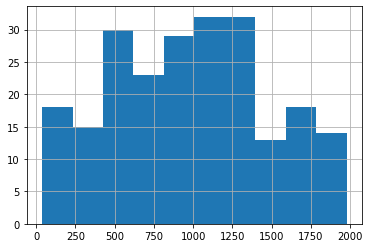

In [107]:
df['len'].hist()

In [108]:
df['len'].describe()

count     224.000000
mean      976.339286
std       492.760269
min        38.000000
25%       578.750000
50%       976.000000
75%      1311.250000
max      1977.000000
Name: len, dtype: float64

In [109]:
df_filtered = pd.read_csv(filtered_file_path, sep='|', names=['title', 'len', 'url'])

<AxesSubplot:>

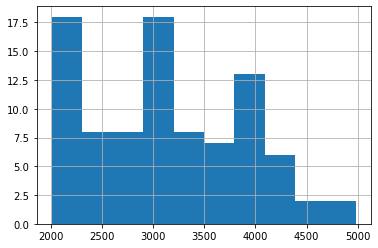

In [110]:
df_filtered['len'][df_filtered['len'] < 5000].hist()

In [111]:
df_filtered['len'].describe()

count       140.000000
mean       9653.407143
std       18290.968940
min        2011.000000
25%        2918.000000
50%        3871.500000
75%        7200.250000
max      150530.000000
Name: len, dtype: float64